In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from utilities.data_processing import ProcessInput
%matplotlib inline

# Modelling LFC results

Attempt to build a model to predict the result of a liverpool game

### Load fixture history data

Currently only interested in the Premier League, so limit the data to that for now

In [2]:
file_path = os.path.join('data', 'liverpool_fixture_history.csv')
df = pd.read_csv(file_path)
df = df[df['competition'] == 'Premier League']
df.head(5)

,away_score,competition,date,home_score,nth_game_this_season,opposition,venue
64,0,Premier League,14/08/1993,2,1,Sheffield Wednesday,Anfield
65,1,Premier League,18/08/1993,3,2,Queens Park Rangers,Loftus Road
66,0,Premier League,22/08/1993,5,3,Swindon Town,County Ground
67,2,Premier League,25/08/1993,1,4,Tottenham Hotspur,Anfield
68,0,Premier League,28/08/1993,2,5,Leeds United,Anfield


## Feature extraction

Use predefined transformation method to add in additional features including:

- A scaled version of the date to act as a weight column, giving more weight to more recent games
- Extracting the day of week from the data column, as well as days since last game
- Drop the venue column after converting it to a home/away flag
- Add the current win streak and undefeated streaks as integers
- Create a beatability index for each oppositon based on previous performance against them

In [3]:
processor = ProcessInput()
df = processor.fit_transform(df)
df.head()

,competition,date,nth_game_this_season,opposition,liverpool_at_home,result,liverpool_goals_scored,opposition_goals_scored,win_flag,loss_flag,...,win_streak,undefeated_streak,pl_gameweek,PPG,season_number,season_points,GFPG,GAPG,GDPG,n_times_teams_played
0,Premier League,1.000000,29,39,True,1,5.0,0.0,True,False,...,0,1,0,1.368421,0,26,1.789474,1.578947,0.210526,13
1,Premier League,0.999551,28,0,False,0,3.0,3.0,False,False,...,0,0,19,1.388889,24,25,1.722222,1.500000,0.222222,48
2,Premier League,0.998989,27,7,False,2,0.0,4.0,False,True,...,0,2,18,1.470588,24,25,1.823529,1.352941,0.470588,5
3,Premier League,0.998539,26,43,True,0,0.0,0.0,False,False,...,0,1,17,1.500000,24,24,1.937500,1.437500,0.500000,23
4,Premier League,0.998202,25,17,True,0,1.0,1.0,False,False,...,0,0,16,1.533333,24,23,2.000000,1.466667,0.533333,47


### Average performance vs specific opposition

A beatability index gives an indication of how well Liverpool plays against each team in the premier league.

For any given opposition, it is simply:

\begin{align}
b_{opp} = \frac{games\ won_{opp}}{total\ games_{opp}} - \frac{games\ lost_{opp}}{total\ games_{opp}}
\end{align}



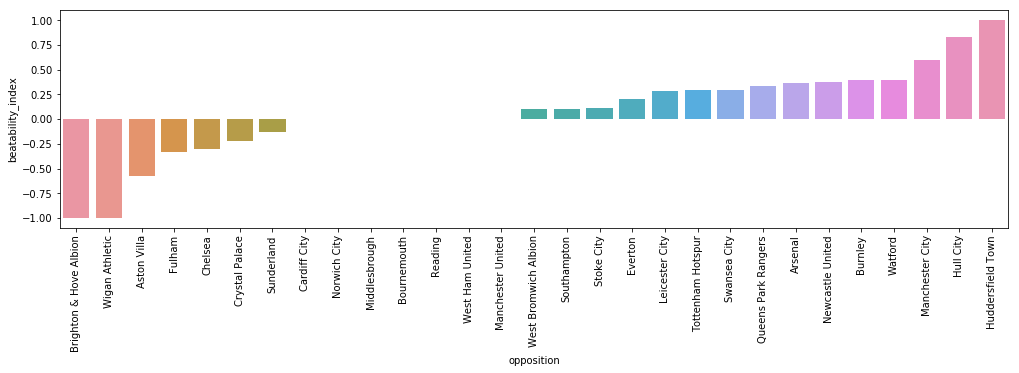

In [4]:
plt.figure(figsize=[17, 4])
barplot = sns.barplot(x='opposition', y='beatability_index', data=processor.beatability_df.sort_values(by='beatability_index'))
for label in barplot.get_xticklabels():
    label.set_rotation(90)

### Performance as season progresses

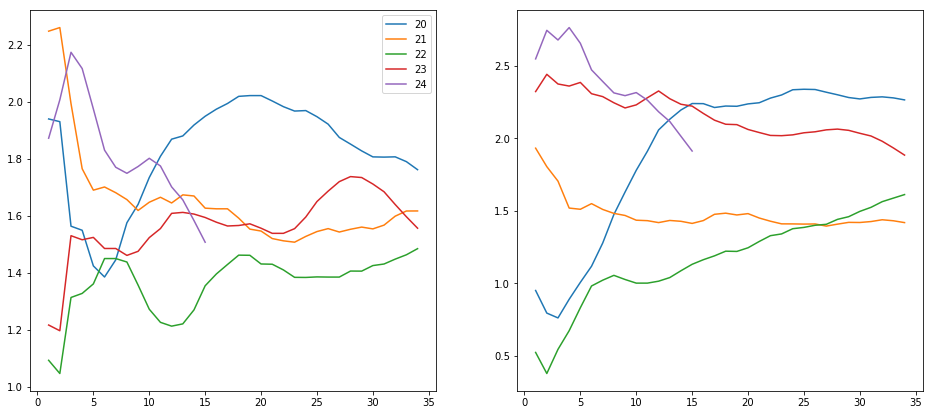

In [5]:
seasons_to_plot = 5

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=[16,7])

for season in range(df['season_number'].max()+1 - seasons_to_plot, df['season_number'].max()+1):
    season_df = df[df['season_number'] == season]   
    axs[0].plot(season_df['pl_gameweek'], season_df['PPG'].rolling(5).mean(), label=season)
    axs[1].plot(season_df['pl_gameweek'], season_df['GFPG'].rolling(5).mean(), label=season)
    
axs[0].legend()
plt.show()

### Drop data that we can't use in training

In [6]:
# Only interested in the Premier League for now
df = df[df['competition'] == 'Premier League']
df.drop('competition', axis=1, inplace=True)

In [7]:
# Scores can't be used in prediction
df.drop(['liverpool_goals_scored', 'opposition_goals_scored'], axis=1, inplace=True)

In [8]:
# Drop any other features we don't want to use in training
df.drop(['season_number', 'season_points'], axis=1, inplace=True)

### Correlation of features with label

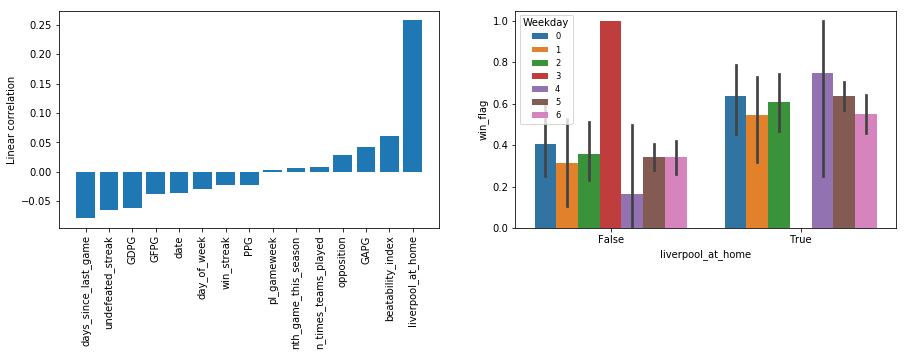

In [9]:
# Calculate correlation matrix then extract the correlations with respect to the win flag
corr_mat = df.corr()
correlation_with_win = corr_mat['win_flag']
correlation_with_win = correlation_with_win[~np.isin(correlation_with_win.index.values, 
                                                     ['win_flag', 'result', 'loss_flag'])]
correlation_with_win.sort_values(inplace=True)

# Plot these correlations
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=[15,4])
ax[0].bar(np.arange(len(correlation_with_win)), correlation_with_win)
ax[0].set_xticks(np.arange(len(correlation_with_win)))
ax[0].set_xticklabels(correlation_with_win.index.values, rotation=90)
ax[0].set_ylabel('Linear correlation')

# Plot a bar chart to see how home advantage and day of week affect the win rate
sns.barplot(data=df, x='liverpool_at_home', y='win_flag', hue='day_of_week', ax=ax[1])
ax[1].legend(loc=2, title='Weekday', fontsize='small')
plt.show()

So home advantage has the strongest linear relationship by a way, and appears to be most important on Fridays! (`weekday = 4`)

In [10]:
# Also drop the win_flag after its been used for visualsiation
df.drop(['win_flag', 'loss_flag'], axis=1, inplace=True)

# Kill any nulls left at this stage for now
#TODO revise?
df.dropna(axis=0, inplace=True)

### Create a stratified test set

In [11]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
df.reset_index(inplace=True, drop=True)
for train_index, test_index in split.split(df, df['result']):
    train = df.loc[train_index]
    test = df.loc[test_index]

In [12]:
sample_comparison = pd.DataFrame({
    'overall': df['result'].value_counts().sort_index() / len(df),
    'stratified': test['result'].value_counts().sort_index() / len(test),
    })
sample_comparison['strat. % error'] = 100 * (sample_comparison['stratified'] - sample_comparison['overall']) \
                                     / sample_comparison['overall']
sample_comparison

,overall,stratified,strat. % error
0,0.253052,0.254144,0.431327
1,0.476138,0.475138,-0.209919
2,0.270810,0.270718,-0.033964


In [13]:
# Separate the labels
y_train = train.pop('result')
y_test = test.pop('result')

# Drop dates, but keep the training dates as a weight
train_weight = train.pop('date')
test.drop('date', axis=1, inplace=True)

### Scale data

Both sets of data need to be scaled before they can be run through a NN

In [14]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaled_train = scaler.fit_transform(train)
scaled_test = scaler.transform(test)

In [15]:
from sklearn.preprocessing import OneHotEncoder

label_onehot = OneHotEncoder(sparse=False)
y_train_nn = label_onehot.fit_transform(y_train.values.reshape(-1, 1))
y_test_nn = label_onehot.transform(y_test.values.reshape(-1, 1))

### Build a NN model

#### Construct the graph

In [16]:
import tensorflow as tf


n_inputs = scaled_train.shape[1]  # Number of input features
n_hidden1 = 300  # Number of neurons in first hidden layer
n_hidden2 = 100  # Number of neurons in second hidden layer
n_outputs = 3  # Number of possible outputs/classes

In [17]:
# Initialise tensorboard stuff
from datetime import datetime

now = datetime.utcnow().strftime('%Y%m%d%H%M%S')
root_logdir = 'tf_logs'
logdir = '{}/run-{}'.format(root_logdir, now)

In [18]:
# Create placeholders for the inputs and outputs
X = tf.placeholder(tf.float32, shape=(None, n_inputs), name='X')
y = tf.placeholder(tf.int64, shape=(None), name='y')

In [19]:
# Create the hidden and output layers
with tf.name_scope('dnn'):
    hidden1 = tf.layers.dense(X, n_hidden1, name='hidden1',activation=tf.nn.relu)
    hidden2 = tf.layers.dense(hidden1, n_hidden2, name='hidden2',activation=tf.nn.relu)
    logits = tf.layers.dense(hidden2, n_outputs, name='outputs')

In [20]:
# Define loss function
with tf.name_scope('loss'):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name='loss')

In [21]:
# Create optimiser
learning_rate = 0.01

with tf.name_scope('train'):
    optimiser = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
    training_op = optimiser.minimize(loss)

In [22]:
# Define evaluation metric
with tf.name_scope('eval'):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

In [23]:
# Create an initialiser and a model saver
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [24]:
acc_summary = tf.summary.scalar('Accuracy', accuracy)
file_writer = tf.summary.FileWriter(logdir, tf.get_default_graph())

#### Train

In [25]:
def next_batch(batch_size, data, labels):
    '''
    Return a random batch of samples and labels. 
    '''
    idx = np.arange(0 , len(data))
    np.random.shuffle(idx)
    idx = idx[:batch_size]
    data_shuffle = data[idx, :]
    labels_shuffle = labels[idx]

    return np.asarray(data_shuffle), np.asarray(labels_shuffle)

In [26]:
n_epochs = 40
batch_size = 50

In [27]:
with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for iteration in range(len(scaled_train) // batch_size):
            X_batch, y_batch = next_batch(batch_size, scaled_train, np.array(y_train))
            sess.run(training_op, feed_dict={X: X_batch, y: np.array(y_batch)})
        
        acc_train = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        acc_test = accuracy.eval(feed_dict={X: scaled_test, y: y_test})
        
        # Tensorboard
        summary_str = acc_summary.eval(feed_dict={X: X_batch, y: y_batch})
        step = epoch
        file_writer.add_summary(summary_str, step)
        
        print(epoch, "Train accuracy: ", acc_train, "Test accuracy: ", acc_test)
        
    save_path = saver.save(sess, 'models/nn_model.ckpt')
    file_writer.close()

0 Train accuracy:  0.38 Test accuracy:  0.475138
1 Train accuracy:  0.58 Test accuracy:  0.475138
2 Train accuracy:  0.36 Test accuracy:  0.475138
3 Train accuracy:  0.48 Test accuracy:  0.475138
4 Train accuracy:  0.5 Test accuracy:  0.475138
5 Train accuracy:  0.5 Test accuracy:  0.475138
6 Train accuracy:  0.42 Test accuracy:  0.475138
7 Train accuracy:  0.48 Test accuracy:  0.475138
8 Train accuracy:  0.42 Test accuracy:  0.475138
9 Train accuracy:  0.46 Test accuracy:  0.475138
10 Train accuracy:  0.4 Test accuracy:  0.475138
11 Train accuracy:  0.62 Test accuracy:  0.475138
12 Train accuracy:  0.46 Test accuracy:  0.475138
13 Train accuracy:  0.44 Test accuracy:  0.475138
14 Train accuracy:  0.52 Test accuracy:  0.475138
15 Train accuracy:  0.5 Test accuracy:  0.475138
16 Train accuracy:  0.48 Test accuracy:  0.475138
17 Train accuracy:  0.42 Test accuracy:  0.475138
18 Train accuracy:  0.5 Test accuracy:  0.475138
19 Train accuracy:  0.52 Test accuracy:  0.475138
20 Train accura

#### Infer

In [28]:
with tf.Session() as sess:
    saver.restore(sess, 'models/nn_model.ckpt')
    Z = logits.eval(feed_dict={X: scaled_test})
    y_pred = np.argmax(Z, axis=1)

INFO:tensorflow:Restoring parameters from models/nn_model.ckpt


#### Evaluate

NN classification accuracy =  	 54.14%


C:\Users\James\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


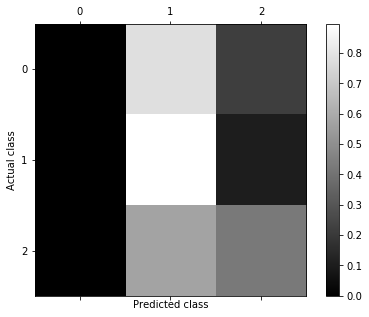

In [29]:
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score

# Simple accuracy score
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average=None)
recall = recall_score(y_test, y_pred, average=None)
print("NN classification accuracy =  \t {:.2f}%".format(100*accuracy))

# Visualise the confusion matrix, normalised for classification frequency
conf_matrix = confusion_matrix(y_test, y_pred)
row_sums = conf_matrix.sum(axis=1, keepdims=True)
norm_conf_matrix = conf_matrix / row_sums
# np.fill_diagonal(norm_conf_matrix, 0)

fig, ax = plt.subplots(figsize=[7,5])
conf_plot = ax.matshow(norm_conf_matrix, cmap=plt.cm.gray)
plt.xlabel('Predicted class')
plt.ylabel('Actual class')
plt.colorbar(ax=ax, mappable=conf_plot)
plt.show()

In [30]:
print(precision)
print(recall)

[ 0.          0.54609929  0.525     ]
[ 0.          0.89534884  0.42857143]


Lighter colors represent larger numbers in that position, so in this case we can see a lot of the errors are coming from draws (actual = 0) predicted to be wins (prediction = 1) in the centre-top position.

Second worst are losses predicted to be wins. This strongly indicates that winning predictions are the most wrong.

Sound like Liverpool?!

### Predict a given game

In [31]:
train.head(1)

,nth_game_this_season,opposition,liverpool_at_home,beatability_index,day_of_week,days_since_last_game,win_streak,undefeated_streak,pl_gameweek,PPG,GFPG,GAPG,GDPG,n_times_teams_played
749,43,0,False,0.363636,0,9,0,5,31,1.6,1.533333,1.0,0.533333,48


In [32]:
# Upcoming game info
pred_game_date = '2018-01-14'
pred_game_opp = 'Manchester City'
liverpool_at_home = True
game_number_this_season = 29
days_since_last_game = 7
curr_win_streak = 3
curr_undefeated_streak = 7
pl_gameweek = 23
curr_PPG = 2

In [33]:
given_opp = processor.opposition_encoder.transform([pred_game_opp])
given_opp[0]

24

In [34]:
given_opp_times_played = processor.opposition_count_dict[given_opp[0]]
given_opp_times_played

37

In [35]:
pred_perf_metric = \
    processor.beatability_df.loc[ processor.beatability_df['opposition'] == pred_game_opp, 'beatability_index'].values
pred_perf_metric[0]

0.59999999999999998

In [36]:
pred_game = np.array([
    game_number_this_season,
    given_opp[0],
    liverpool_at_home,
    pred_perf_metric[0],
    pd.to_datetime(pred_game_date, format='%Y-%m-%d').weekday(),
    days_since_last_game,
    curr_win_streak,
    curr_undefeated_streak,
    given_opp_times_played,
    pl_gameweek,
    curr_PPG
], dtype='O').reshape([1, len(train.columns)])

ValueError: cannot reshape array of size 11 into shape (1,14)

In [ ]:
y_prob_live = clf.predict(pred_game)
y_pred_live = y_prob_live.argmax(axis=1)

In [ ]:
if liverpool_at_home:
    home_flag = 'H'
else:
    home_flag = 'A'
print('| {}: {} ({})| {:.2f} | {:.2f} | {:.2f} |  |  |  | '.format(pred_game_date, pred_game_opp, home_flag, 
                                                                   100*y_prob_live[0][1], 100*y_prob_live[0][0], 
                                                                   100*y_prob_live[0][2]))

In [ ]:
print('Win probability: \t {:.2f}%'.format(100*y_prob_live[0][1]))
print('Loss probability: \t {:.2f}%'.format(100*y_prob_live[0][2]))
print('Draw probability: \t {:.2f}%'.format(100*y_prob_live[0][0]))

In [ ]:
feature_contributions = clf.predict(pred_game, pred_contrib=True)
ind = np.arange(len(clf.feature_importance()))

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=[15,5])
ax[0].bar(ind, clf.feature_importance())
ax[1].bar(ind, feature_contributions.ravel()[:-1])
for axs in ax:
    axs.set_xticks(np.arange(len(clf.feature_importance())))
    axs.set_xticklabels(clf.feature_name(), rotation=90)
plt.show()

In [ ]:
# Calculate log loss of prediction given actual result
from sklearn.metrics import log_loss

y_actual_live = np.array([[0, 1, 0]]) 
log_loss(y_actual_live, y_prob_live)